# Fire Hazard Incidents Analytics Pipeline
## Civilian Severity vs Average Losses in dollars

## Importing Required Libraries

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

from storedb import save_in_db, IMG_PATH

## Creating Spark Session and using all available cores

In [3]:
%%time
spark = SparkSession \
    .builder \
    .appName("532: Project") \
    .config("local[4]") \
    .getOrCreate()

22/12/11 20:28:31 WARN Utils: Your hostname, Janhvis-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.109 instead (on interface en0)
22/12/11 20:28:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/11 20:28:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
CPU times: user 18.2 ms, sys: 21.3 ms, total: 39.5 ms
Wall time: 2.53 s


## Loading civilian casuality and basic module data

In [4]:
%%time
civilian_casualities_df = spark.read.options(delimiter="^", header=True).csv("civiliancasualty.txt")
basic_module_df = spark.read.options(delimiter="^", header=True).csv("basicincident.txt")

CPU times: user 4 ms, sys: 2.95 ms, total: 6.95 ms
Wall time: 2.96 s


In [5]:
%%time
# Dropping null values in loss tables and finding total loss
basic_module_df = basic_module_df.na.drop(subset=("PROP_LOSS","CONT_LOSS"))
total_loss = basic_module_df.groupBy("INCIDENT_KEY").agg(F.sum(basic_module_df.PROP_LOSS + basic_module_df.CONT_LOSS).alias("TOTAL_LOSS"))

CPU times: user 4.97 ms, sys: 2.86 ms, total: 7.83 ms
Wall time: 100 ms


In [6]:
%%time
# Finding Civilian Injury Severity vs. Dollar Loss
civilian_dollar_loss = total_loss.join(civilian_casualities_df, total_loss.INCIDENT_KEY == civilian_casualities_df.INCIDENT_KEY)
cdl_df = civilian_dollar_loss.groupBy("SEV").agg(F.avg("TOTAL_LOSS").alias("AVG_LOSS"))


CPU times: user 4.94 ms, sys: 2.41 ms, total: 7.35 ms
Wall time: 63.3 ms


CPU times: user 57.8 ms, sys: 7.36 ms, total: 65.2 ms
Wall time: 120 ms


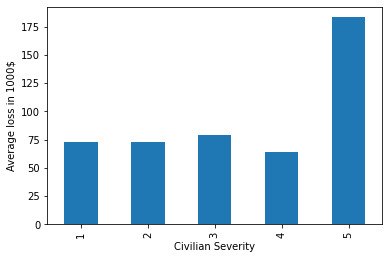

In [9]:
%%time
p_cdl_df = cdl_df.toPandas()
p_cdl_df["AVG_LOSS"] = p_cdl_df["AVG_LOSS"]/1000
p1 = p_cdl_df.drop([2]).sort_values(by="SEV").plot(x="SEV", y="AVG_LOSS", xlabel="Civilian Severity", ylabel = "Average loss in 1000$", kind="bar", legend = False)
fig1 = p1.get_figure()
fig_name = "civilian_dollar_loss.png"
fig1.savefig(f"{IMG_PATH}{fig_name}")

# saving to db
save_in_db(fig_name, "civilian_severity_vs_dollar_losses")
